# Interpretable Machine Learning for Credit Risk Modeling using SHAP Values

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix

# XGBoost and SHAP
import xgboost as xgb
import shap

In [2]:
# Load dataset
df = pd.read_csv("synthetic_german_credit_spil.csv")

# Preview first few rows
df.head()

,CustomerID,Age,Sex,Job,Housing,SavingAccount,CheckingAccount,CreditAmount,Duration,Purpose,...,Telephone,MaritalStatus,Dependents,EmploymentSince,CreditHistory,RiskScore,LoanApproved,Region,Income,EducationLevel
0,CUST0000,56,Male,Management,Own,Moderate,NaN,5086,59,Furniture,...,Yes,Married,0,7,Paid,682,0,North,8679,High School
1,CUST0001,69,Female,Skilled,Own,Rich,NaN,8930,67,Car,...,No,Single,2,7,Delayed,687,0,North,3675,Bachelor
2,CUST0002,46,Female,Highly Skilled,Rent,Moderate,<0,2845,6,Business,...,Yes,Divorced,1,26,Critical,384,1,North,8124,PhD
3,CUST0003,32,Male,Skilled,Free,Rich,NaN,16959,54,Education,...,No,Divorced,0,28,Paid,809,1,West,6781,PhD
4,CUST0004,60,Male,Highly Skilled,Free,Unknown,>=200,10048,30,Business,...,Yes,Single,2,6,Paid,736,1,East,4236,Bachelor


In [3]:
# Encode object-type columns
df_encoded = df.copy()
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

df_encoded.head()

,CustomerID,Age,Sex,Job,Housing,SavingAccount,CheckingAccount,CreditAmount,Duration,Purpose,...,Telephone,MaritalStatus,Dependents,EmploymentSince,CreditHistory,RiskScore,LoanApproved,Region,Income,EducationLevel
0,0,56,1,1,1,1,3,5086,59,3,...,1,1,0,7,3,682,0,1,8679,1
1,1,69,0,2,1,2,3,8930,67,1,...,0,2,2,7,1,687,0,1,3675,0
2,2,46,0,0,2,1,1,2845,6,0,...,1,0,1,26,0,384,1,1,8124,3
3,3,32,1,2,0,2,3,16959,54,2,...,0,0,0,28,3,809,1,3,6781,3
4,4,60,1,0,0,3,2,10048,30,0,...,1,2,2,6,3,736,1,0,4236,0


In [4]:
# Scale selected numerical columns
numerical_cols = ['Age', 'CreditAmount', 'Income', 'Duration', 'RiskScore']
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

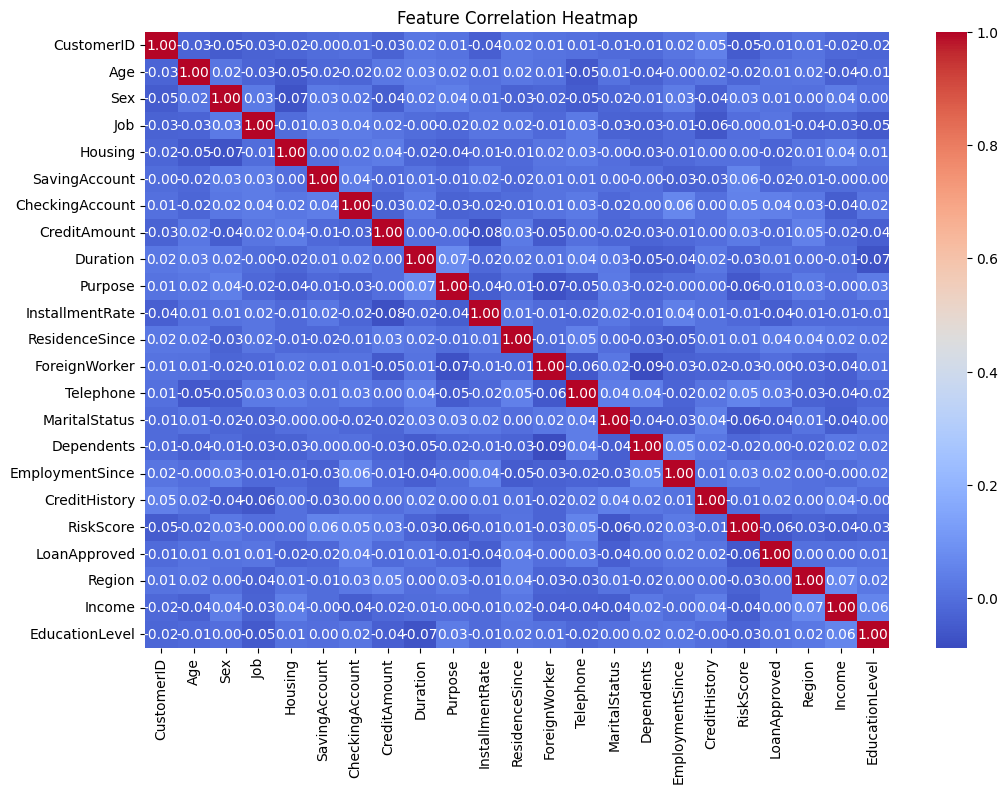

In [15]:
# Visualize feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.savefig("plot png/shap_ Heatmap plot.png", bbox_inches='tight')
plt.show()

In [6]:
# Define features and target
X = df_encoded.drop(['LoanApproved', 'CustomerID'], axis=1)
y = df_encoded['LoanApproved']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Hyperparameter Tuning with GridSearchCV

# Handle class imbalance
ratio = sum(y_train == 0) / sum(y_train == 1)

# Define parameter grid for tuning
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'scale_pos_weight': [ratio]
}

# Create base model (no use_label_encoder needed)
base_model = xgb.XGBClassifier(eval_metric='logloss')

# Run grid search
grid = GridSearchCV(base_model, param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train, y_train)

# Best model from grid search
model = grid.best_estimator_

# Predict and evaluate
y_pred = model.predict(X_test)
print(" Best Parameters:", grid.best_params_)
print(" AUC:", roc_auc_score(y_test, y_pred))
print(" Precision:", precision_score(y_test, y_pred))
print(" Recall:", recall_score(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

 Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 0.9512195121951219}
 AUC: 0.5514905149051491
 Precision: 0.5547945205479452
 Recall: 0.6585365853658537
 Confusion Matrix:
 [[52 65]
 [42 81]]


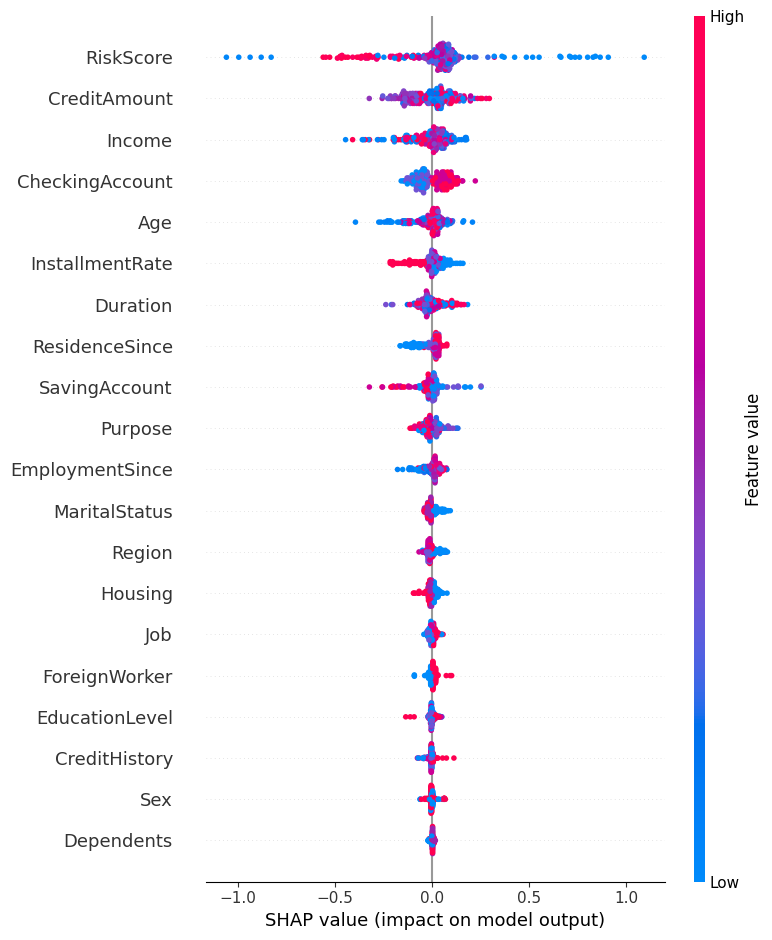

In [12]:
# Create SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("plot png/shap_summary_plot.png", bbox_inches='tight')
plt.show()

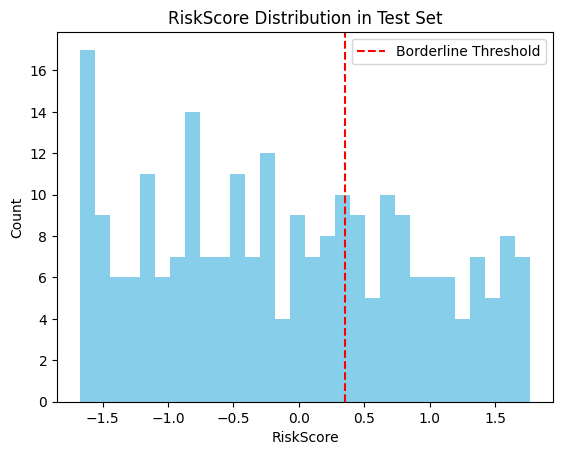

In [14]:
# Visualize RiskScore distribution
X_test_copy = X_test.copy()
X_test_copy['LoanApproved'] = y_test.values
X_test_copy['Prediction'] = model.predict(X_test)
X_test_copy['RiskScore'] = df_encoded.loc[X_test.index, 'RiskScore']

plt.hist(X_test_copy['RiskScore'], bins=30, color='skyblue')
plt.axvline(x=0.35, color='red', linestyle='--', label='Borderline Threshold')
plt.title("RiskScore Distribution in Test Set")
plt.xlabel("RiskScore")
plt.ylabel("Count")
plt.legend()
plt.savefig("plot png/shap_RiskScore dist.png", bbox_inches='tight')
plt.show()

In [16]:
# Select cases
high_risk = X_test_copy[X_test_copy['LoanApproved'] == 0].sort_values('RiskScore').head(1)
low_risk = X_test_copy[X_test_copy['LoanApproved'] == 1].sort_values('RiskScore', ascending=False).head(1)
borderline = X_test_copy[(X_test_copy['RiskScore'] > 0.2) & (X_test_copy['RiskScore'] < 0.5)].head(1)

# Convert index to row position
high_index = X_test.index.get_loc(high_risk.index[0])
low_index = X_test.index.get_loc(low_risk.index[0])
border_index = X_test.index.get_loc(borderline.index[0])

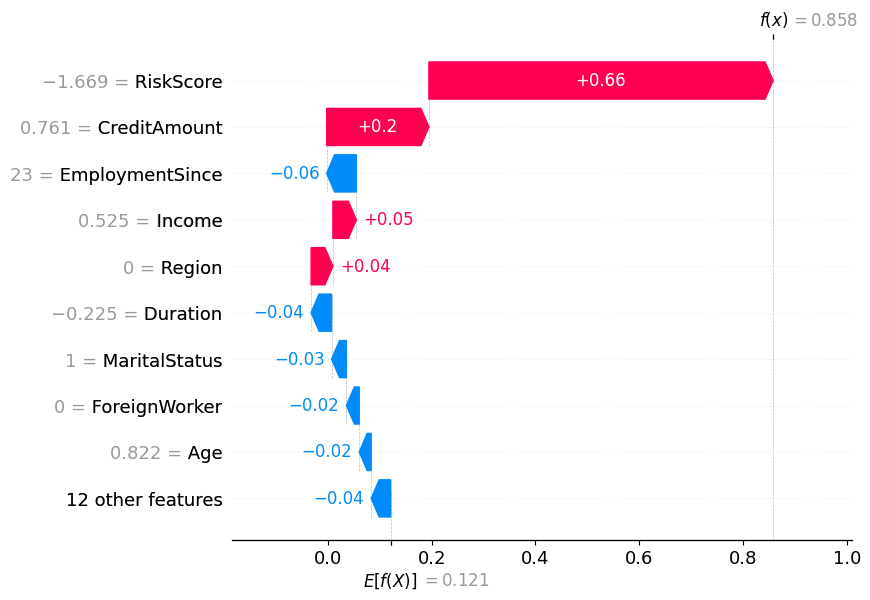

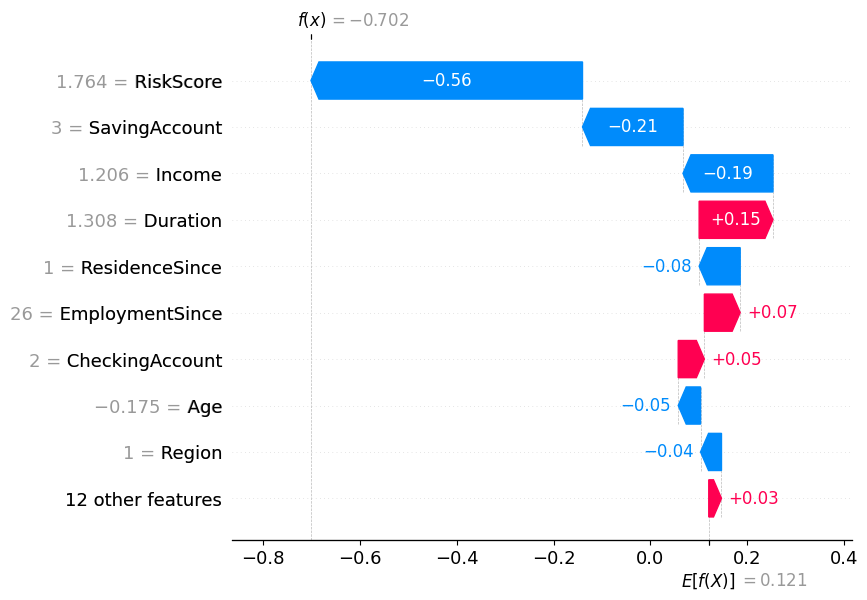

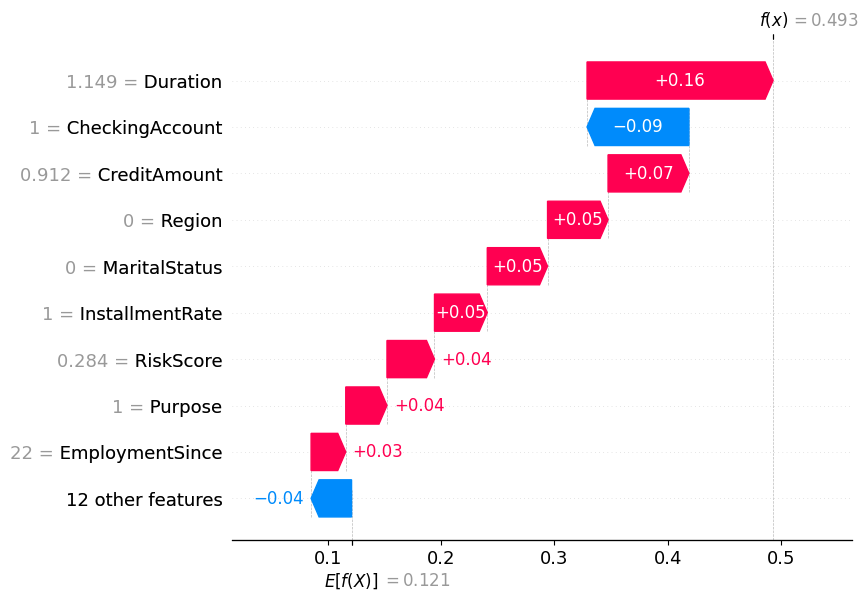

In [19]:
# High-risk denial
fig = plt.figure()
shap.plots.waterfall(shap_values[high_index], show=False)
plt.savefig("plot png/shap_case_high.png", bbox_inches='tight')
plt.show(fig)

# Low-risk approval
fig = plt.figure()
shap.plots.waterfall(shap_values[low_index], show=False)
plt.savefig("plot png/shap_case_low.png", bbox_inches='tight')
plt.show(fig)

# Borderline case
fig = plt.figure()
shap.plots.waterfall(shap_values[border_index], show=False)
plt.savefig("plot png/shap_case_borderline.png", bbox_inches='tight')
plt.show(fig)

##  SHAP Instance-Level Analysis

###  High-Risk Denial
- Prediction: Denied
- Key Drivers: High CreditAmount, long Duration, low CheckingAccount balance.

###  Low-Risk Approval
- Prediction: Approved
- Key Drivers: High Income, stable Job, long EmploymentSince.

###  Borderline Case
- Prediction: Mixed
- Key Drivers: Conflicting signals from CreditHistory and Housing.

### -----End of Project-----